In [2]:
import random
from pathlib import Path

import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

import utils

In [3]:
# directorys with data and to store training checkpoints and logs
DATA_DIR = Path("TrainingData") # pathlib library is used to handle paths

# data settings 
NO_VALIDATION_PATIENTS = 2
IMAGE_SIZE = [64, 64]
BATCH_SIZE = 32

In [4]:
# find patient folders in training directory
# excluding hidden folders (start with .)
patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]
random.shuffle(patients)

# split in training/validation after shuffling
partition = {
    "train": patients[:-NO_VALIDATION_PATIENTS],
    "validation": patients[-NO_VALIDATION_PATIENTS:],
}

In [6]:
# load training data and create DataLoader with batching and shuffling
dataset = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

IndexError: list index out of range

In [5]:
# load validation data
valid_dataset = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE, valid=True)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

In [6]:
input, target = next(iter(valid_dataloader))

In [7]:
print(input.shape)

torch.Size([32, 1, 64, 64])


In [1]:
plt.subplot(121)
plt.imshow(input[9,0,...], cmap="gray")
plt.axis("off")
plt.subplot(122)
plt.imshow(target[9,0,...], cmap="gray")
plt.axis("off")
plt.show()

NameError: name 'plt' is not defined

In [9]:
input, target = next(iter(dataloader))

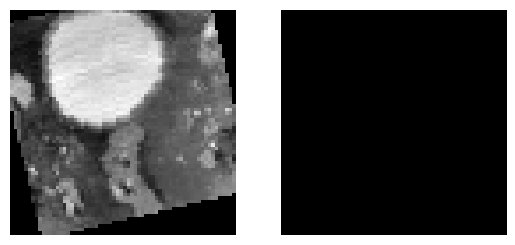

In [10]:
plt.subplot(121)
plt.imshow(input[7,0,...], cmap="gray")
plt.axis("off")
plt.subplot(122)
plt.imshow(target[7,0,...], cmap="gray")
plt.axis("off")
plt.show()